In [1]:
!pip install portalocker>=2.0.0

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/'
import sys
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive


%pwd
%ls

/content/gdrive/My Drive/Colab Notebooks
 CNNMNIST.ipynb                     show_activations.ipynb
'Copy of act_functions.ipynb'       stage/
'Copy of VGG16_bnorm_start.ipynb'   stats/
 expe_learning_rate.ipynb           tps/
 expe_regularisation.ipynb          transformer_encoder_state_dict_0.pth
 harmonie/                          transformer_encoder_state_dict_1.pth
 IMG_20221028_181514813.jpg         transformer_encoder_state_dict_2.pth
 IMG_20221028_181638225.jpg         transformer_encoder_state_dict_3.pth
 IMG_20221028_181800152.jpg         transformer_encoder_state_dict.pth
 IMG_20221028_181923835.jpg         Transformer.ipynb
 IMG_20221028_181959973.jpg         Untitled0.ipynb
 IMG_8080~2.jpg                     VGG16_bnorm_load_and_train.ipynb
 mini-dalle/                        VGG16_bnorm_start.ipynb
 rl_test/


In [5]:
# Set up the tokenizer
tokenizer = get_tokenizer('basic_english')

# Function to yield list of tokens
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Construct the vocab
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Define the collate function for padding
def collate_batch(batch):
    label_list, text_list = [], []
    for (_text, _label) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(_text, dtype=torch.int64)
        text_list.append(processed_text)
    return torch.tensor(label_list, dtype=torch.float32).to(device), pad_sequence(text_list, padding_value=0.0).transpose(0,1).to(device)

class TextClassificationDataset(Dataset):
    def __init__(self, data_iter, text_pipeline, label_pipeline):
        self.data = []
        for label, text in data_iter:
            self.data.append((text_pipeline(text), label_pipeline(label)))

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

# Set up data processing pipelines
text_pipeline = lambda x: vocab(tokenizer(x))

# Simply return the label as an integer
label_pipeline = lambda x:[0.,1.] if x==2 else [1.,0.]

# Define the datasets
train_dataset = TextClassificationDataset(train_iter, text_pipeline, label_pipeline)
test_dataset = TextClassificationDataset(test_iter, text_pipeline, label_pipeline)

# Set up the DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

In [6]:
#PositionLinear
class PositionLinear(nn.Module):
  def __init__(self, embed_dim):
        super().__init__()
        self.fc = torch.nn.Linear(embed_dim,embed_dim)

  def forward(self, text):
    return torch.nn.ReLU()(self.fc(text))

In [7]:
#Multi-Head SA
class MHSA(nn.Module):
  def __init__(self, embed_dim, num_heads, out_dim):
    super().__init__()
    self.embed_dim=embed_dim
    self.num_heads=num_heads
    self.out_dim=out_dim
    #K,Q,V for each head
    self.K = nn.Linear(embed_dim,out_dim*num_heads)
    self.Q = nn.Linear(embed_dim,out_dim*num_heads)
    self.V = nn.Linear(embed_dim,out_dim*num_heads)

    #the final linear
    self.final = nn.Linear(out_dim*num_heads,embed_dim)


  def forward(self, text):
    seq_len = text.shape[1]
    #all heads at once and then split
    K = self.K(text).view(text.shape[0],seq_len,self.num_heads,self.out_dim)
    Q = self.Q(text).view(text.shape[0],seq_len,self.num_heads,self.out_dim)
    V = self.V(text).view(text.shape[0],seq_len,self.num_heads,self.out_dim)

    #perform self-attention
    W = torch.matmul(Q,K.transpose(2,3))
    W = torch.softmax(W/torch.sqrt(torch.tensor(self.embed_dim)).detach(),dim=-1)
    Y = torch.matmul(W,V)

    Y = Y.flatten(start_dim=-2)

    return self.final(Y)

In [8]:
class NonCausalBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, out_dim):
        super().__init__()
        #layernorm
        self.ln1 = torch.nn.LayerNorm(embed_dim)
        #MHSA
        self.MHSA = MHSA(embed_dim,num_heads,out_dim)
        #layernorm
        self.ln2 = torch.nn.LayerNorm(out_dim)
        #PositionLinear
        self.PL = PositionLinear(embed_dim)

  def forward(self, text):
    text_bis = self.ln1(text)
    text_bis = self.MHSA(text_bis)
    text_bis = self.ln1(text_bis)
    text_bis = self.PL(text_bis)
    return text + text_bis

In [9]:
import math
import torchtext.vocab as Vocab

class TransformerEncoder(nn.Module):
  #choose embed dim amongst 50, 100, 200 or 300.
    def __init__(self, embed_dim, vocab_size, num_heads, hidden_dim, num_blocks, max_len=3000):
        super().__init__()
        self.max_len=max_len
        self.embed_dim = embed_dim
        #embedding
        glove = Vocab.GloVe(name='6B', dim=embed_dim)
        self.word_embed = nn.Embedding(400000, embed_dim)
        self.word_embed.weight.data.copy_(glove.vectors)


        #positional encoding
        self.pos_enc = self.positional_encoding(max_len, embed_dim).to(device)

        #list of blocks
        blocks = [NonCausalBlock(embed_dim,num_heads,hidden_dim)]+[NonCausalBlock(hidden_dim,num_heads,hidden_dim) for _ in range(num_blocks-1)]
        self.blocks = nn.Sequential(*blocks)

        #final linear output maps to label probabilities
        self.final = nn.Linear(hidden_dim,2)

    def forward(self, text):
        text = self.word_embed(text)
        text = text + self.pos_enc[:, :text.size(1), :]  # Use pre-computed positional encodings
        text = self.blocks(text)
        text = text.sum(dim=1)  #sum along sequence to get to single vector
        text = self.final(text)
        return text

    @staticmethod
    def positional_encoding(max_len, embed_dim):
        """
        Compute positional encoding for positions up to max_len.
        """
        # Initialize a tensor to store the positional encodings
        pos_enc = torch.zeros(max_len, embed_dim)

        # Compute the positional encodings
        for pos in range(max_len):
            for i in range(0, embed_dim, 2):
                pos_enc[pos, i] = math.sin(pos / (10000 ** ((2 * i) / embed_dim)))
                if i + 1 < embed_dim:
                    pos_enc[pos, i + 1] = math.cos(pos / (10000 ** ((2 * i) / embed_dim)))

        return pos_enc.unsqueeze(0).detach()  # Add a batch dimension


In [10]:
#TEST : define a model, see its output, check all the sizes along the way
test = TransformerEncoder(100,len(vocab),8,100,4).to(device)
test_in = next(iter(train_loader))
test(test_in[1])

tensor([[-169.5874,   67.3846],
        [-183.3572,   37.7532],
        [-109.8675,  265.7747],
        [-196.8227,   18.5393],
        [-184.7354,   44.4931],
        [-191.5265,   43.0534],
        [-183.0580,   30.2869],
        [-198.0848,   18.4817]], device='cuda:0', grad_fn=<AddmmBackward0>)

Training: 100%|██████████| 3125/3125 [17:59<00:00,  2.89it/s, loss=1.16]


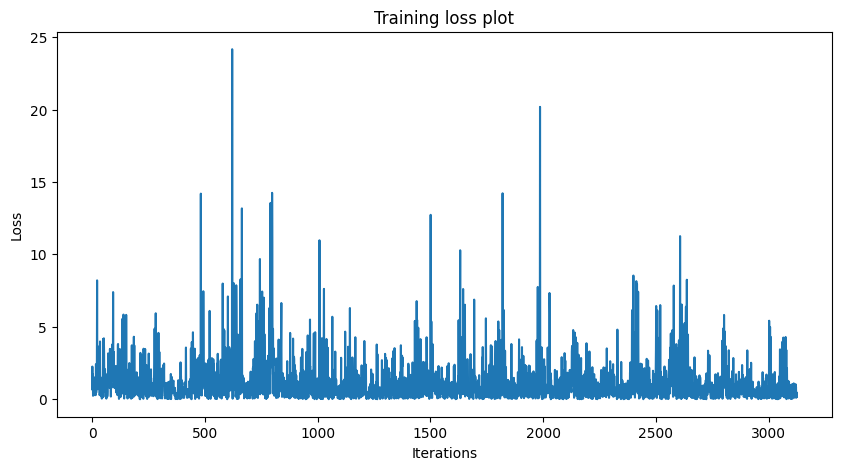

Training: 100%|██████████| 3125/3125 [18:02<00:00,  2.89it/s, loss=1]


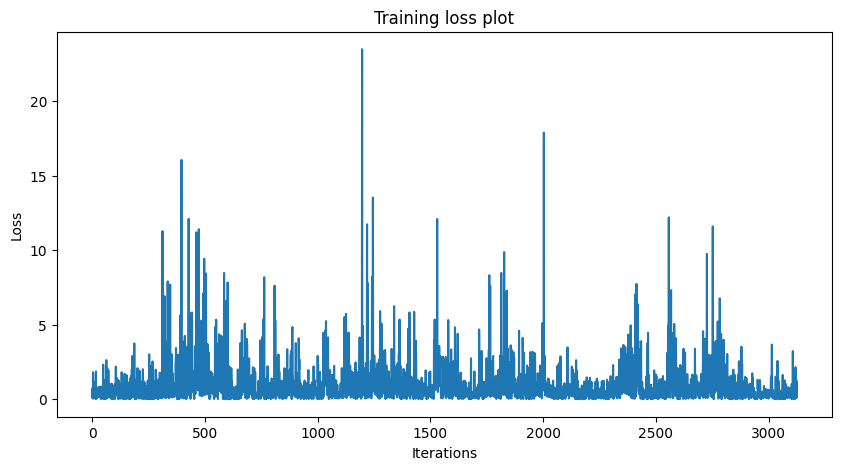

Training: 100%|██████████| 3125/3125 [18:00<00:00,  2.89it/s, loss=1.07]


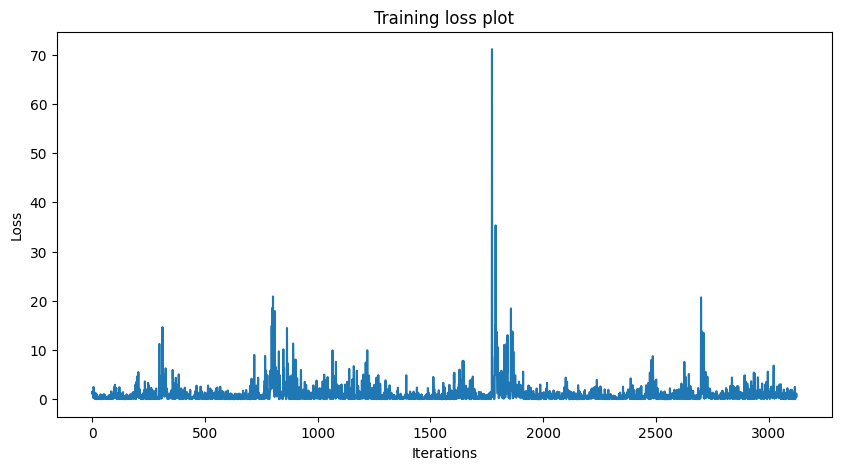

Training: 100%|██████████| 3125/3125 [18:04<00:00,  2.88it/s, loss=0.903]


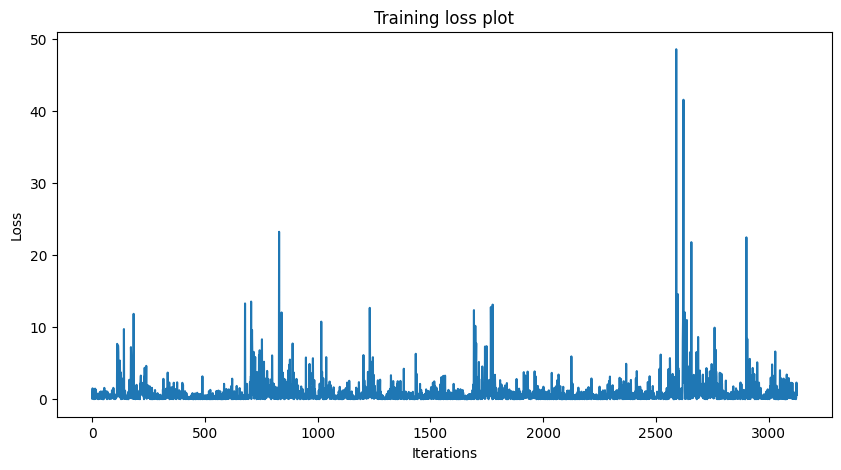

Training: 100%|██████████| 3125/3125 [18:00<00:00,  2.89it/s, loss=0.705]


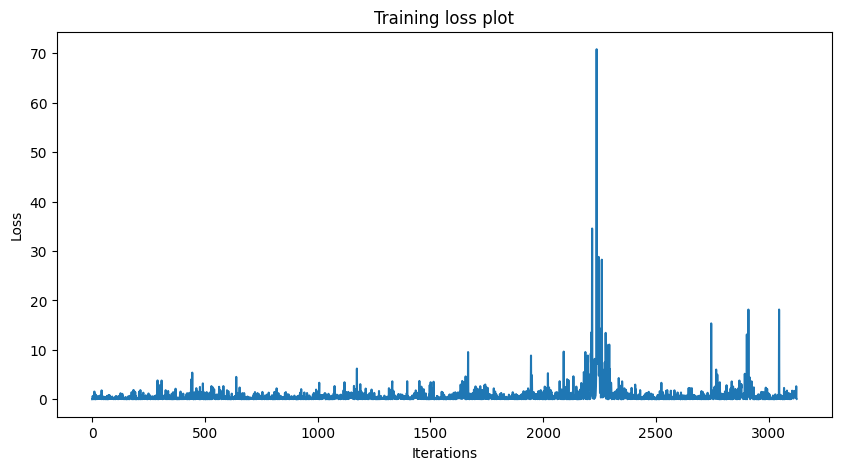

Training: 100%|██████████| 3125/3125 [18:05<00:00,  2.88it/s, loss=0.554]


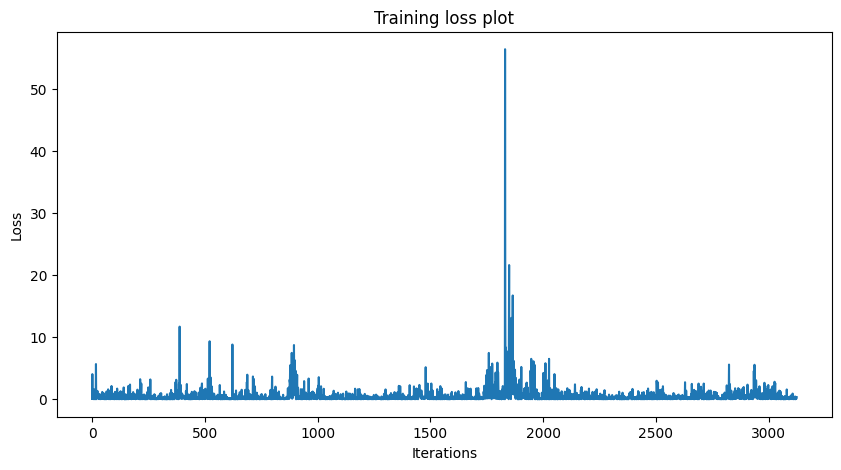

Training: 100%|██████████| 3125/3125 [18:07<00:00,  2.87it/s, loss=0.528]


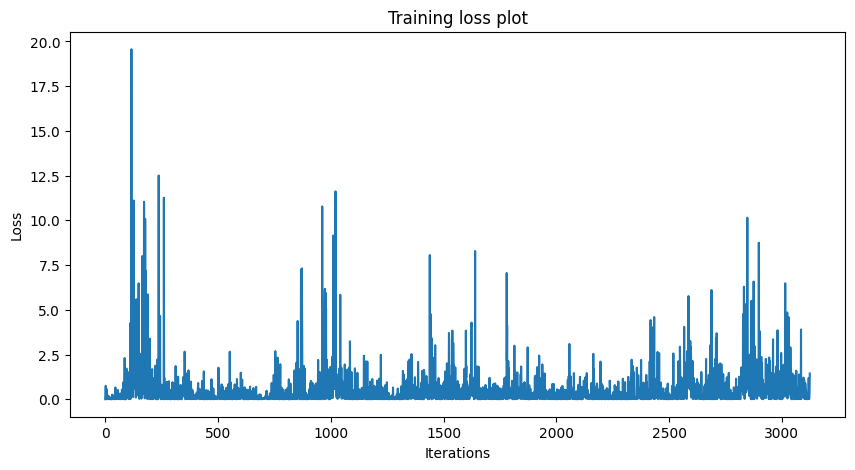

Training: 100%|██████████| 3125/3125 [17:58<00:00,  2.90it/s, loss=0.447]


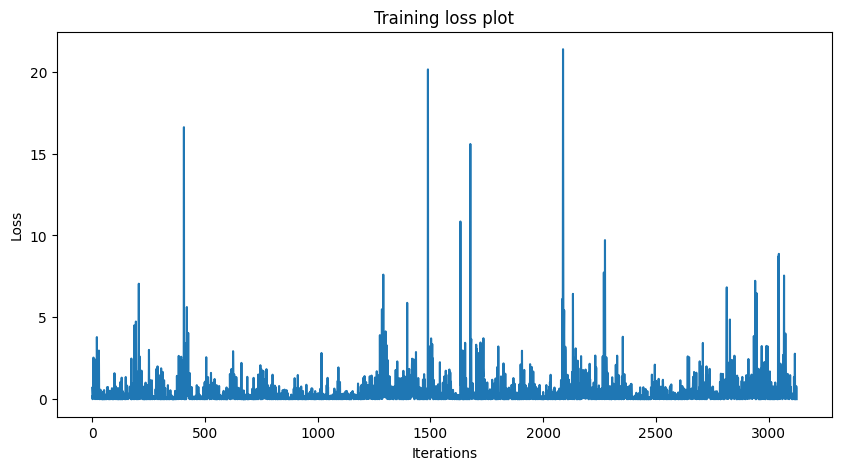

Training: 100%|██████████| 3125/3125 [18:02<00:00,  2.89it/s, loss=0.374]


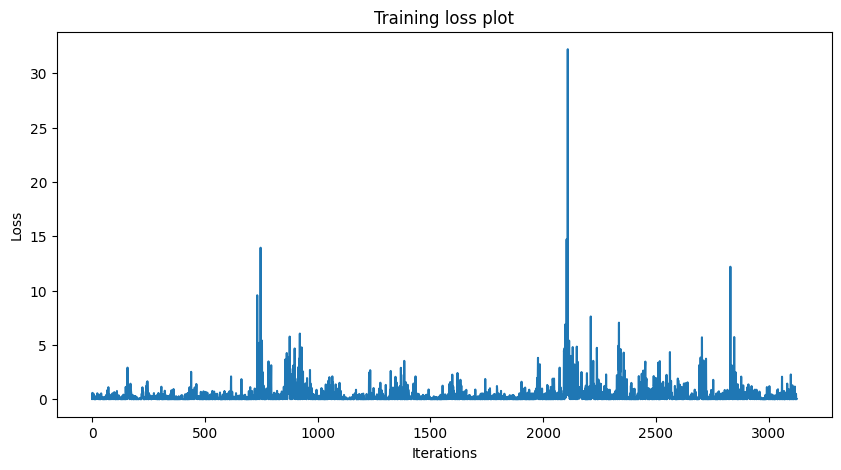

Training: 100%|██████████| 3125/3125 [18:01<00:00,  2.89it/s, loss=0.281]


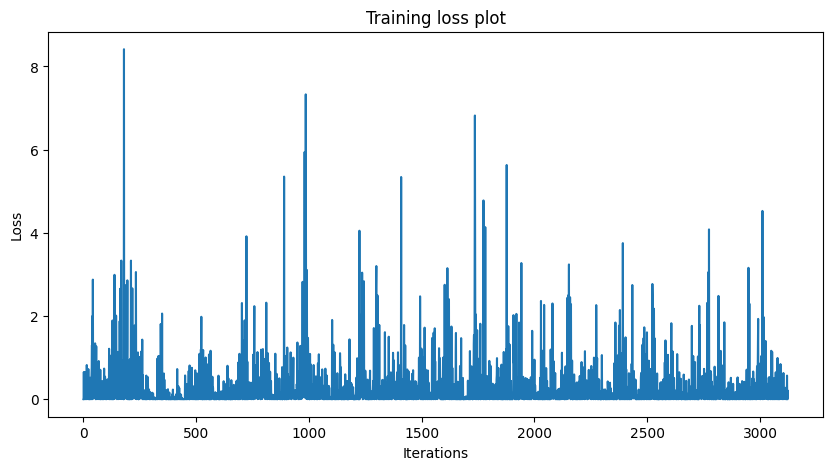

Training: 100%|██████████| 3125/3125 [18:06<00:00,  2.88it/s, loss=0.399]


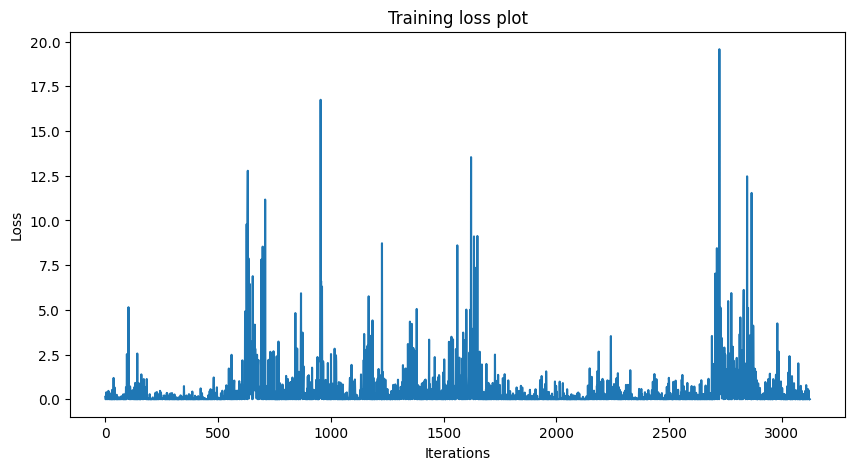

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-fdbd9ead2b87>", line 39, in <cell line: 38>
    torch.save(model.state_dict(), './transformer_encoder_state_dict_'+str(i)+'.pth')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: Parent directory . does not exist.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPyth

In [ ]:
# Loss and optimizer
model = TransformerEncoder(embed_dim=300, vocab_size=10000, num_heads=8, hidden_dim=300, num_blocks=8, max_len=3000).to(device)
model.load_state_dict(torch.load('./transformer_encoder_state_dict.pth'))
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

from tqdm import tqdm

# Training loop
def train(model, loader):
    model.train()
    total_loss = 0
    loss_list = []
    progress_bar = tqdm(loader, desc="Training", total=len(loader))
    for i, (text, labels) in enumerate(progress_bar):
        labels, text = text.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(text)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loss_list.append(loss.item())
        progress_bar.set_postfix({'loss': total_loss/(i+1)})
    return loss_list

import matplotlib.pyplot as plt

def plot_loss(loss_list):
    plt.figure(figsize=(10,5))
    plt.plot(loss_list)
    plt.title("Training loss plot")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

# Assuming loss_list is the returned value from the train function
for i in range(100):#20 epochs
  torch.save(model.state_dict(), './transformer_encoder_state_dict_'+str(i)+'.pth')
  loss_list = train(model, train_loader)
  plot_loss(loss_list)


In [ ]:
torch.save(model.state_dict(), './transformer_encoder_state_dict.pth')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-6454765534f0>", line 1, in <cell line: 1>
    torch.save(model.state_dict(), './transformer_encoder_state_dict.pth')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: Parent directory . does not exist.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/inter

In [ ]:
def compute_accuracy(model, data_loader, limit=1000):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Deactivate gradients for the following code
        for i, (labels, texts) in enumerate(data_loader):
            # Break the loop when the limit is exceeded
            if i * data_loader.batch_size >= limit:
                break

            # Move labels and texts to the same device as the model
            labels = labels.to(device)
            texts = texts.to(device)

            # Get raw predictions (logits)
            logits = model(texts)

            # Convert logits to class predictions
            labels = torch.argmax(labels, dim=-1)
            predictions = torch.argmax(logits, dim=-1)

            # Compare with true labels
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.numel()

    # Compute the accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

train_accuracy = compute_accuracy(model, train_loader, limit=1000)
test_accuracy = compute_accuracy(model, test_loader, limit=1000)

print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

In [ ]:
def plot_positional_encodings(model, num_encodings=100):
    # Ensure num_encodings isn't larger than model's max_len
    num_encodings = min(num_encodings, model.max_len)

    # Detach the positional encodings from the model and move them to cpu
    pos_encodings = model.pos_enc[0, :num_encodings, :].detach().cpu().numpy()

    plt.figure(figsize=(12, 8))
    plt.pcolormesh(pos_encodings, cmap='viridis')
    plt.xlabel('Embedding Dimensions')
    plt.xlim((0, model.embed_dim))
    plt.ylim((num_encodings, 0))
    plt.ylabel('Token Position')
    plt.colorbar()
    plt.title('Positional Encoding Values')
    plt.show()

# Plot the first 10 positional encodings
plot_positional_encodings(model, num_encodings=3000)

KeyboardInterrupt: ignored